<a href="https://colab.research.google.com/github/JHWannabe/Self_Directed_Project/blob/main/week3/Color_image_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data GAN-Colorization
!unzip -q Victorian400-GAN-colorization-data.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 36 (delta 12), reused 17 (delta 5), pack-reused 0
Unpacking objects: 100% (36/36), done.
Downloading...
From: https://drive.google.com/uc?id=1tPNnwPISjPaC1nDZ1QpXcJAQCFmeO3Uv
To: /content/Victorian400-GAN-colorization-data.zip
100% 508M/508M [00:08<00:00, 60.6MB/s]
Victorian400-GAN-colorization-data.zip download complete!


In [2]:
import os
import glob
import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [3]:
class VictorianDataset(Dataset):
    def __init__(self, root, color_transforms_=None, gray_transforms_=None):

        self.color_transforms = transforms.Compose(color_transforms_)
        self.gray_transforms = transforms.Compose(gray_transforms_)
        self.gray_files = sorted(glob.glob(os.path.join(root, 'gray') + "/*.*"))
        self.color_files = sorted(glob.glob(os.path.join(root, 'resized') + "/*.*"))
     
    def __getitem__(self, index):

        gray_img = Image.open(self.gray_files[index % len(self.gray_files)]).convert("L")
        color_img = Image.open(self.color_files[index % len(self.color_files)]).convert("RGB")
    
        gray_img = self.gray_transforms(gray_img)
        color_img = self.color_transforms(color_img)

        return {"A": gray_img, "B": color_img}

    def __len__(self):
        return len(self.gray_files)

In [4]:
root = ''
test_root = root + 'test/'

img_height = 256
img_width = 256

batch_size = 12
test_batch_size = 6

gpu = 0

In [5]:
color_mean = [0.58090717, 0.52688643, 0.45678478]
color_std = [0.25644188, 0.25482641, 0.24456465]
gray_mean = [0.5350533]
gray_std = [0.25051587]

color_transforms_ = [
    transforms.Resize(size=(img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=color_mean, std=color_std),
]

gray_transforms_ = [
    transforms.Resize(size=(img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=gray_mean, std=gray_std),
]

In [6]:
train_loader = DataLoader(
    VictorianDataset(root, color_transforms_=color_transforms_, gray_transforms_=gray_transforms_),
    batch_size=batch_size,
    shuffle=True
)

In [7]:
def reNormalize(img, mean, std):
    img = img.numpy().transpose(1, 2, 0)
    img = img * std + mean
    img = img.clip(0, 1)
    return img  

torch.Size([12, 1, 256, 256]) torch.Size([12, 3, 256, 256])


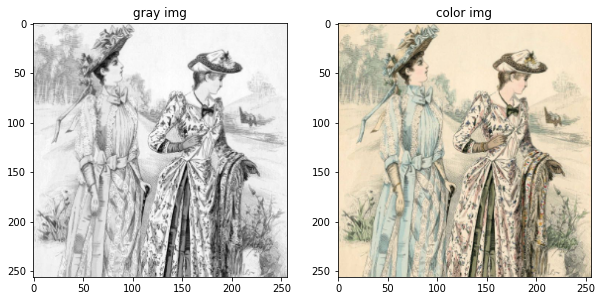

In [8]:
fig = plt.figure(figsize=(10,5))
rows = 1 
cols = 2

for X in train_loader:
    
    print(X['A'].shape, X['B'].shape)
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(reNormalize(X["A"][0], gray_mean, gray_std).reshape(img_height, img_width), cmap='gray') 
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(reNormalize(X["B"][0], color_mean, color_std))
    ax2.set_title('color img')    

    plt.show()
    break

In [9]:
test_loader = DataLoader(
    VictorianDataset(test_root, color_transforms_=color_transforms_, gray_transforms_=gray_transforms_),
    batch_size=test_batch_size,
    shuffle=False
)

torch.Size([6, 1, 256, 256]) torch.Size([6, 3, 256, 256])


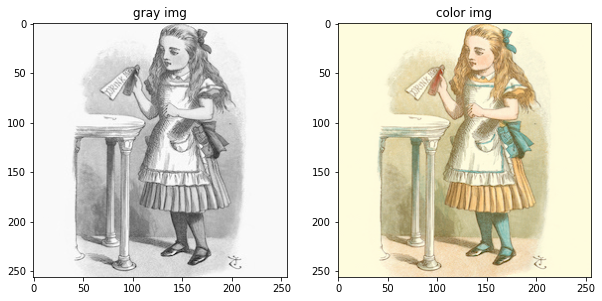

In [10]:
fig = plt.figure(figsize=(10,5))
rows = 1 
cols = 2

for X in test_loader:
    
    print(X['A'].shape, X['B'].shape)
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(reNormalize(X["A"][0], gray_mean, gray_std).reshape(img_height, img_width), cmap='gray')
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(reNormalize(X["B"][0], color_mean, color_std))
    ax2.set_title('color img')    

    plt.show()
    break

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        """noise image + gray image"""
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1)
        )
        
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64 * 2 , 3, 1, 1),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.1)
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        
        self.conv1by1 = nn.Sequential(
            nn.Conv2d(64,64,1,1,0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1)
        )
        
        
        self.conv = nn.Sequential(
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, input):
        output1 = self.conv1(input)
        pool1 = self.maxpool(output1)
        output2 = self.conv2(pool1)
        output3 = self.upsample(output2) + output1
        output4 = self.conv1by1(output3)
        out = self.conv(output4)        
        return out

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3,64,kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(64,128,kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(128, 128, kernel_size = 1, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(512, 1024, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace = True),
            
            )
        
        
        self.fc = nn.Sequential(
            nn.Linear(1024 * 8 * 8 , 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, batch_size),
            nn.Sigmoid()
        )
        
    def forward(self, input, b_size):
        output = self.main(input)
        output = self.fc(output.view(b_size,-1))
        return output

In [13]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:        
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1: 
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [14]:
Gener = Generator().cuda(gpu) if torch.cuda.is_available() else Generator()
Gener.apply(weights_init)

Generator(
  (conv1): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (upsample): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv1by1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(nega

In [15]:
Discri = Discriminator().cuda(gpu) if torch.cuda.is_available() else Discriminator()
Discri.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, af

In [16]:
max_epoch = 50
optimizerD = torch.optim.Adam(Discri.parameters(), lr = 0.0002,betas = (0.5, 0.999))
optimizerG = torch.optim.Adam(Gener.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [ ]:
for epoch in range(max_epoch):
    start_time = datetime.datetime.now()
    loss_D = 0.0
    for i, data in enumerate(train_loader):
        grays, color = data['A'], data['B']
        b_size = len(data['A'])
        

        ######## 생성모델(Generator) 학습 ########
        ######## Train Generator ########
        noise = torch.randn(b_size, 1, img_height, img_width).uniform_(0,1)
        gray_noise = Variable(torch.cat([grays,noise],dim=1).cuda(gpu))
        fake_img = Gener(gray_noise)
        output = Discri(fake_img,b_size)
        g_loss = torch.mean((output-1)**2)
        

        ######## 역전파 & 생성모델 최적화 ########
        ######## Backpropagation & Optimize G ########
        Discri.zero_grad()
        Gener.zero_grad()
        g_loss.backward()
        optimizerG.step()


        ######## 판별모델(Discriminator) 학습 ########
        ######## Train Discriminator ########
        color = Variable(color.cuda(gpu))
        noise = torch.randn(b_size, 1, img_height, img_width).uniform_(0,1)   
        gray_noise = Variable(torch.cat([grays,noise],dim=1).cuda(gpu))   


        ######## 판별모델이 컬러 이미지를 진짜(real)로 인식하도록 학습 ########
        ######## Train d to recognize color image as real ########
        output = Discri(color,b_size)
        real_loss = torch.mean((output-1)**2)
        

        ######## 판별모델이 흑백 이미지를 가짜(fake)로 인식하도록 학습 ########
        ######## Train d to recognize fake image as fake ########        
        fake_img = Gener(gray_noise)   
        output = Discri(fake_img,b_size)
        fake_loss = torch.mean(output**2)
        

        ######## 역전파 & 판별모델 최적화 ########
        ######## Backpropagation & Optimize D ########
        d_loss = real_loss + fake_loss
        Discri.zero_grad()
        Gener.zero_grad()
        d_loss.backward()
        optimizerD.step()        


        fake_img = torchvision.utils.make_grid(fake_img.data) 

    epoch_time = datetime.datetime.now() - start_time
    if (epoch + 1) % 5 == 0:
        torch.save(Gener.state_dict(), "generator_%d.pth" % (epoch+1))
        torch.save(Discri.state_dict(), "discriminator_%d.pth" % (epoch+1))

        print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] ETA: %s" % (epoch+1, max_epoch, i+1, len(train_loader), d_loss.item(), g_loss.item(), epoch_time))
        plt.imshow(reNormalize(fake_img.cpu(), color_mean, color_std))
        plt.show()      

In [ ]:
Gener.load_state_dict(torch.load("generator_35.pth" ))
Discri.load_state_dict(torch.load("discriminator_35.pth" ))

In [ ]:
Discri.eval()
Gener.eval()

fixed_noise = torch.randn(test_batch_size, 1, img_height, img_width).uniform_(0,1)

for i, data in enumerate(test_loader,0) :
    images, label = data['A'], data['B']

    if len(data['A']) != test_batch_size:
        continue

    grays = torch.from_numpy(np.resize(images.numpy(), (test_batch_size, 1, img_height, img_width)))    
    gray = Variable(torch.cat([grays,fixed_noise],dim = 1).cuda(gpu))
    
    output = Gener(gray)

    inputs = torchvision.utils.make_grid(grays)
    labels = torchvision.utils.make_grid(label)
    out = torchvision.utils.make_grid(output.data)

    print('==================input==================')
    plt.imshow(reNormalize(inputs.cpu(), gray_mean, gray_std))
    plt.show()
    print('==================target==================')
    plt.imshow(reNormalize(labels.cpu(), color_mean, color_std))
    plt.show()
    print('==================output==================')
    plt.imshow(reNormalize(out.cpu(), color_mean, color_std))
    plt.show()